In [1]:
import sys
sys.path.append('/home/linxuangao')

import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import torch
import umap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import scipy

from GPNSF.model import GPNSFModel
from GPNSF.utils import *


import warnings
warnings.filterwarnings("ignore")

/home/linxuangao/.conda/envs/glx/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 指定GPU设备索引
gpu_id = 1  # 使用第4张GPU（索引从0开始）
torch.cuda.set_device(gpu_id)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

print(f'Using device: {device}')
print(f'Current GPU: {torch.cuda.current_device()}')

Using device: cuda
Current GPU: 1


In [3]:
data_dir = '/home/linxuangao/data_gpnsf/Mouse_Spleen'

In [4]:
adata1 = sc.read_h5ad(f'{data_dir}/adata_RNA.h5ad')
# adata2 = sc.read_h5ad(f'{data_dir}/adata_peaks_normalized.h5ad')
adata2 = sc.read_h5ad(f'{data_dir}/adata_Pro.h5ad')

In [5]:
print(adata1)
print(adata2)

AnnData object with n_obs × n_vars = 2653 × 32285
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2653 × 21
    obsm: 'spatial'


In [6]:
sc.pp.filter_genes(adata1, min_counts=50)
print(f"RNA: 过滤后基因数: {adata1.n_vars}")
    
    # 2. 选择高变基因
sc.pp.highly_variable_genes(
        adata1, 
        n_top_genes=3000,
        flavor='seurat_v3'
    )
adata1 = adata1[:, adata1.var['highly_variable']].copy()
print(f"RNA: 选择 {adata1.n_vars} 个高变基因")
    
# 3. 标准化
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)

RNA: 过滤后基因数: 12051
RNA: 选择 3000 个高变基因


In [7]:
X_1 = adata1.X
p = X_1.shape[1]
X_2 = adata2.X
q = X_2.shape[1]
S = adata1.obsm['spatial']

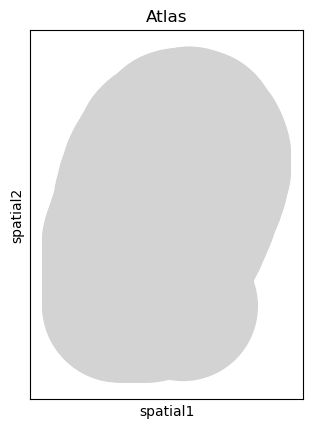

In [8]:
sc.pl.spatial(adata1, spot_size=100, title='Atlas')

In [9]:
K = 8
M = 1284

In [10]:
# 重新加载 GPNSF 并将 numpy/sparse 转为 torch 张量
# from importlib import reload
# import GPNSF.model as gp_model
# reload(gp_model)
from GPNSF.model import GPNSFModel

import numpy as np
import scipy.sparse as sp

def to_torch_tensor(x, device, dtype=torch.float32):
    if hasattr(x, "toarray"):
        x = x.toarray()  # scipy.sparse -> ndarray
    if isinstance(x, np.ndarray):
        return torch.as_tensor(x, dtype=dtype, device=device)
    if isinstance(x, torch.Tensor):
        return x.to(device=device, dtype=dtype)
    raise TypeError(f"Unsupported type: {type(x)}")

S_t = to_torch_tensor(S, device, dtype=torch.float32)
X1_t = to_torch_tensor(X_1, device, dtype=torch.float32)
X2_t = to_torch_tensor(X_2, device, dtype=torch.float32)

print('Converted ->', 'S:', S_t.shape, 'X1:', X1_t.shape, 'X2:', X2_t.shape, 'device=', device)

Converted -> S: torch.Size([2653, 2]) X1: torch.Size([2653, 3000]) X2: torch.Size([2653, 21]) device= cuda


In [11]:
from tqdm import tqdm
# 构建模型与训练循环（周期性打印 loss/ELBO/KL）
model = GPNSFModel(S=S_t, p=p, q=q, K=K, M=M, eta=10.0, num_mc_samples=3, likelihood_x2='poi', 
                   omega_type='chol', kernel_type='matern32').to(device)

# 修改1: 初始学习率设为1e-3
opt = torch.optim.Adam(model.parameters(), lr=5e-3)  # 原为 lr=5e-4

@torch.no_grad()
def compute_loglik_terms(model, X1, X2):
    # 与模型内部保持一致的 Monte Carlo 估计，并适配 X2 的两种似然模式
    W1, W2 = model.get_W1_W2()
    theta1 = model.theta1
    Hs = model.sample_H()  # (S, n, K)
    loglik1 = []
    loglik2 = []
    if model.likelihood_x2 == 'nb':
        lambda2_nb = model.lambda2_nb
    elif model.likelihood_x2 == 'bernoulli':
        lambda2_ber = model.lambda2_ber
        X2_bin = (X2 > 0).to(X2.dtype)
    else:
        lambda2_poi = model.lambda2_poi
    for t in range(Hs.size(0)):
        H = Hs[t]
        Y1 = torch.exp(H) @ W1
        Y2 = torch.exp(H) @ W2
        loglik1.append(nb_log_prob(X1, Y1, theta1).sum())
        if model.likelihood_x2 == 'nb':
            loglik2.append(nb_log_prob(X2, Y2, lambda2_nb).sum())
        elif model.likelihood_x2 == 'ber':
            p2 = torch.clamp(Y2 * lambda2_ber, min=1e-8, max=1.0 - 1e-8)
            loglik2.append(bernoulli_log_prob(X2_bin, p2).sum())
        else:    
            loglik2.append(poisson_log_prob(X2, Y2*lambda2_poi).sum())
    loglik1 = torch.stack(loglik1).mean()
    loglik2 = torch.stack(loglik2).mean()
    return loglik1, loglik2

num_steps = 10000
print_every = 500

# 修改2: 计算切换学习率的步数
switch_step = int(num_steps * 0.75)  # 前40%步数后切换

for step in tqdm(range(1, num_steps + 1), total=num_steps):
    opt.zero_grad()
    loss = model(X1_t, X2_t)  # 负ELBO
    loss.backward()
    opt.step()

    # 修改3: 在达到切换步数时降低学习率
    if step == switch_step:
        for param_group in opt.param_groups:
            param_group['lr'] = 5e-4
        print(f"\n[step {step:03d}] Learning rate changed to 5e-4")

    if step == 1 or step % print_every == 0:
        with torch.no_grad():
            elbo_val = model.elbo(X1_t, X2_t)
            kl_val = model.compute_KL_u()
            loglik1, loglik2 = compute_loglik_terms(model, X1_t, X2_t)
            current_lr = opt.param_groups[0]['lr']  # 添加显示当前学习率
            print(f"[step {step:03d}] loss={loss.item():.3f}  ELBO={elbo_val.item():.3f}  "
                  f"KL={kl_val.item():.3f}  loglik1={loglik1.item():.3f}  "
                  f"loglik2={loglik2.item():.3f}  lr={current_lr:.1e}")  # 添加学习率显示

print('Training finished.')

  0%|          | 2/10000 [00:00<1:00:21,  2.76it/s]

[step 001] loss=23984108.000  ELBO=-23663174.000  KL=1856.474  loglik1=-9674032.000  loglik2=-13976231.000  lr=5.0e-03


  5%|▌         | 501/10000 [01:17<29:44,  5.32it/s]

[step 500] loss=11245380.000  ELBO=-11205217.000  KL=10729.604  loglik1=-7872477.500  loglik2=-3296658.500  lr=5.0e-03


 10%|█         | 1001/10000 [02:33<26:04,  5.75it/s]

[step 1000] loss=9136369.000  ELBO=-9121290.000  KL=8229.617  loglik1=-7120872.000  loglik2=-1926005.500  lr=5.0e-03


 15%|█▌        | 1501/10000 [03:50<23:45,  5.96it/s]

[step 1500] loss=7516039.000  ELBO=-7491013.500  KL=9824.712  loglik1=-6724141.500  loglik2=-690318.438  lr=5.0e-03


 20%|██        | 2001/10000 [05:06<23:12,  5.74it/s]

[step 2000] loss=7275662.000  ELBO=-7269315.000  KL=8350.385  loglik1=-6613744.000  loglik2=-566387.625  lr=5.0e-03


 25%|██▌       | 2501/10000 [06:24<23:10,  5.39it/s]

[step 2500] loss=7170293.500  ELBO=-7163165.000  KL=7345.776  loglik1=-6571749.500  loglik2=-524242.500  lr=5.0e-03


 30%|███       | 3001/10000 [07:40<20:43,  5.63it/s]

[step 3000] loss=7090866.000  ELBO=-7098808.000  KL=6505.191  loglik1=-6540712.000  loglik2=-485517.094  lr=5.0e-03


 35%|███▌      | 3501/10000 [08:56<17:25,  6.22it/s]

[step 3500] loss=7029447.500  ELBO=-7034030.000  KL=6066.604  loglik1=-6523347.000  loglik2=-447967.375  lr=5.0e-03


 40%|████      | 4001/10000 [10:13<17:20,  5.76it/s]

[step 4000] loss=6981285.500  ELBO=-6983558.500  KL=5802.821  loglik1=-6504757.500  loglik2=-415302.750  lr=5.0e-03


 45%|████▌     | 4501/10000 [11:29<17:07,  5.35it/s]

[step 4500] loss=6934835.500  ELBO=-6934005.000  KL=5581.827  loglik1=-6494728.000  loglik2=-384880.094  lr=5.0e-03


 50%|█████     | 5000/10000 [12:46<17:23,  4.79it/s]

[step 5000] loss=6900345.000  ELBO=-6898443.000  KL=5565.624  loglik1=-6479608.000  loglik2=-365165.344  lr=5.0e-03


 55%|█████▌    | 5501/10000 [14:04<12:06,  6.19it/s]

[step 5500] loss=6871816.500  ELBO=-6872564.500  KL=5465.344  loglik1=-6472818.000  loglik2=-348012.750  lr=5.0e-03


 60%|██████    | 6001/10000 [15:22<12:34,  5.30it/s]

[step 6000] loss=6850557.500  ELBO=-6849250.500  KL=5364.153  loglik1=-6463025.000  loglik2=-333841.938  lr=5.0e-03


 65%|██████▌   | 6501/10000 [16:39<10:13,  5.70it/s]

[step 6500] loss=6835104.500  ELBO=-6837022.000  KL=5254.370  loglik1=-6457119.000  loglik2=-327093.062  lr=5.0e-03


 70%|███████   | 7001/10000 [17:57<08:19,  6.00it/s]

[step 7000] loss=6825440.000  ELBO=-6824453.000  KL=5149.730  loglik1=-6450965.000  loglik2=-323771.125  lr=5.0e-03


 75%|███████▌  | 7500/10000 [19:16<08:38,  4.82it/s]


[step 7500] Learning rate changed to 5e-4
[step 7500] loss=6816064.000  ELBO=-6814534.500  KL=5034.066  loglik1=-6445309.500  loglik2=-319582.781  lr=5.0e-04


 80%|████████  | 8001/10000 [20:33<07:25,  4.49it/s]

[step 8000] loss=6812265.500  ELBO=-6812554.000  KL=4985.572  loglik1=-6444712.000  loglik2=-318597.469  lr=5.0e-04


 85%|████████▌ | 8501/10000 [21:50<04:22,  5.71it/s]

[step 8500] loss=6812621.000  ELBO=-6812458.500  KL=4967.296  loglik1=-6444585.500  loglik2=-317970.344  lr=5.0e-04


 90%|█████████ | 9001/10000 [23:08<02:56,  5.65it/s]

[step 9000] loss=6810302.500  ELBO=-6810340.500  KL=4951.204  loglik1=-6442085.500  loglik2=-317555.875  lr=5.0e-04


 95%|█████████▌| 9501/10000 [24:26<01:31,  5.44it/s]

[step 9500] loss=6810183.500  ELBO=-6808993.000  KL=4929.988  loglik1=-6442300.000  loglik2=-316694.875  lr=5.0e-04


100%|██████████| 10000/10000 [25:44<00:00,  6.48it/s]

[step 10000] loss=6805491.000  ELBO=-6806414.000  KL=4906.660  loglik1=-6442564.000  loglik2=-316564.594  lr=5.0e-04
Training finished.


In [12]:
with torch.no_grad():
    n = S_t.size(0)
    K_model = model.K
    H_mu = torch.empty(n, K_model, device=S_t.device, dtype=S_t.dtype)
    for k_idx in range(K_model):
        mu_k, _ = model.q_h_params(k_idx)  # (n,), (n,)
        H_mu[:, k_idx] = mu_k
    H_exp = torch.exp(H_mu)

print('H_mu/H_exp shapes ->', H_mu.shape, H_exp.shape)

# 转为 numpy，便于绘图
S_np = S_t.detach().cpu().numpy()
H_mu_np = H_mu.detach().cpu().numpy()
H_exp_np = H_exp.detach().cpu().numpy()

H_mu/H_exp shapes -> torch.Size([2653, 8]) torch.Size([2653, 8])


In [13]:
# 先删除所有以'Factor_'开头的列
factor_cols = [col for col in adata1.obs.columns if col.startswith('Factor_')]
adata1.obs = adata1.obs.drop(columns=factor_cols)

# H_exp_np_normalized = H_exp_np

# row_norms = np.linalg.norm(H_exp_np, axis=1, keepdims=True)
# H_exp_np_normalized = H_exp_np / row_norms

row_sums = H_exp_np.sum(axis=1, keepdims=True)
H_exp_np_normalized = H_exp_np / row_sums


# row_sums = H_exp_np.sum(axis=1, keepdims=True)
# row_means = row_sums / H_exp_np.shape[1]
# threshold = 1.0 * row_means
# H_exp_np_filtered = np.where(H_exp_np < threshold, 0, H_exp_np)
# row_sums_filtered = H_exp_np_filtered.sum(axis=1, keepdims=True)
# H_exp_np_normalized = H_exp_np_filtered / row_sums_filtered


temp = pd.DataFrame(H_exp_np_normalized, columns=[f'Factor_{k+1}' for k in range(H_exp_np_normalized.shape[1])])
temp.index = adata1.obs.index
adata1.obs = adata1.obs.join(temp)

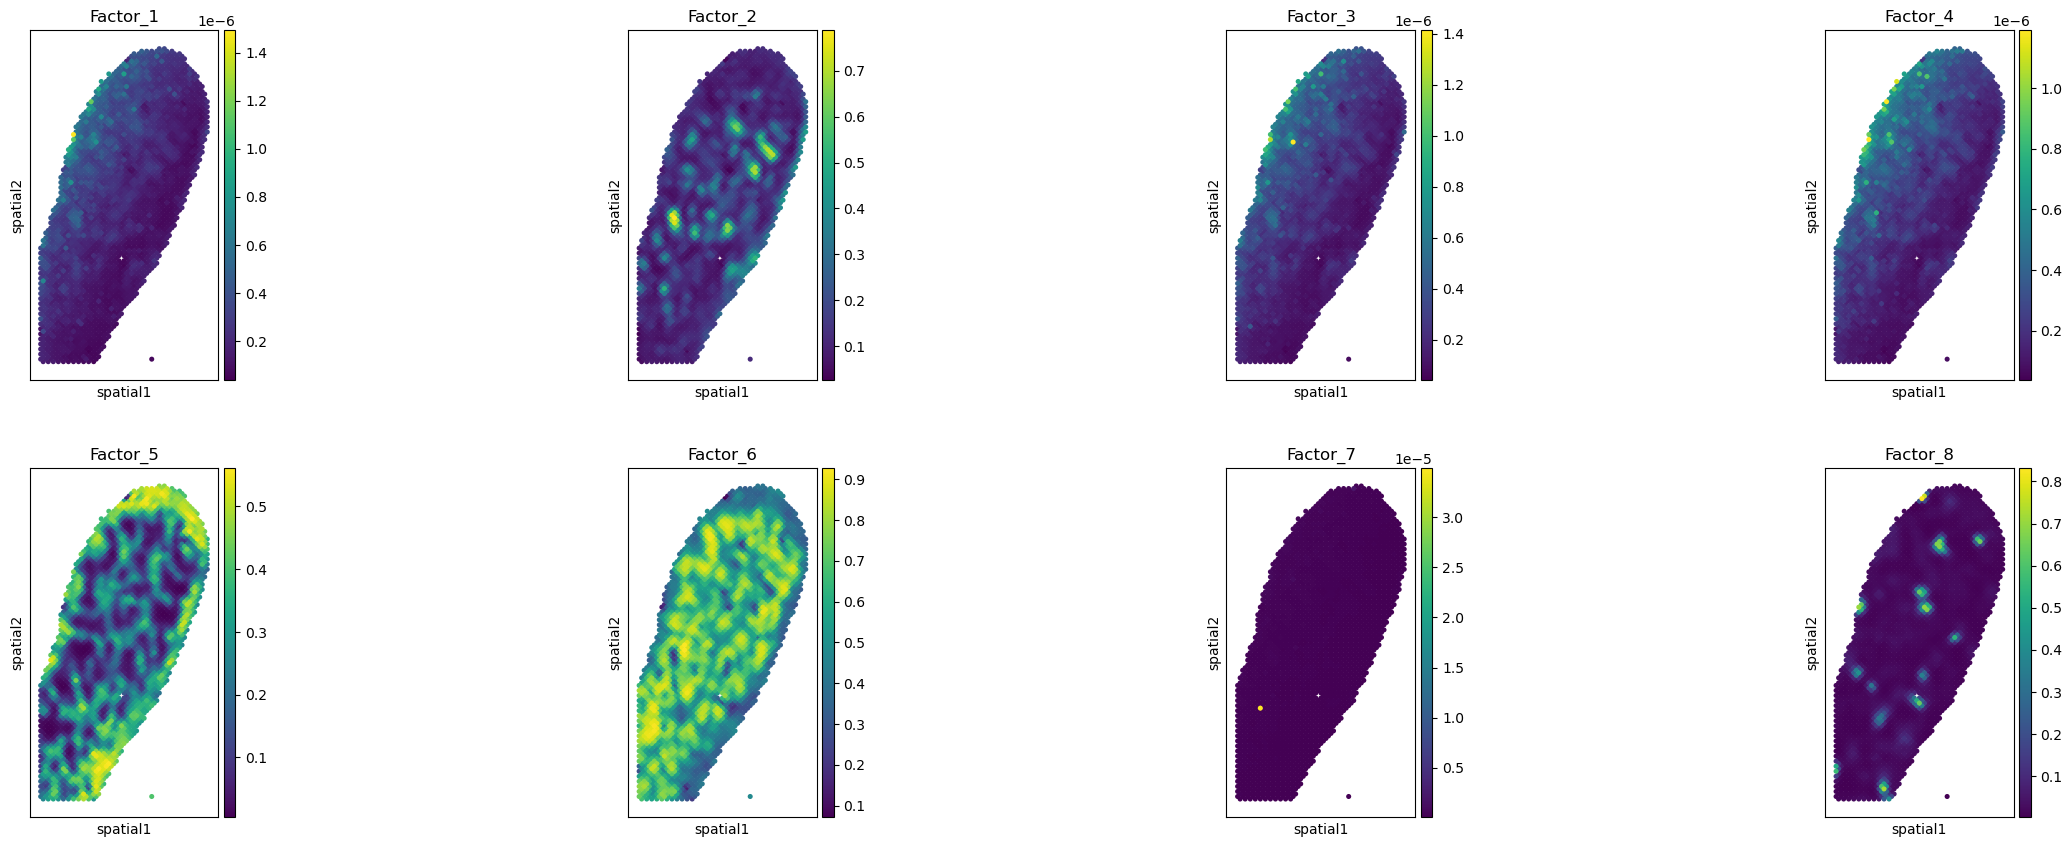

In [14]:
# # 创建图形并保存
# fig = sc.pl.spatial(
#     adata=adata1,
#     color=[f'Factor_{k+1}' for k in range(H_exp_np_normalized.shape[1])],
#     spot_size=0.1,
#     show=False  # 关键：不显示，只返回图形对象
# )

# # 保存图片
# plt.savefig('spatial_factors.png', 
#             dpi=300, 
#             bbox_inches='tight',  # 紧凑布局
#             facecolor='white')    # 背景色
# plt.close()  # 关闭图形，释放内存

sc.pl.spatial(
    adata=adata1,
    color=[f'Factor_{k+1}' for k in range(H_exp_np_normalized.shape[1])],
    spot_size=2)

阈值分析统计结果
总点位数量: 2653
阈值: [0.4, 0.25, 0.6, 0.2]
分析的因子: [1, 4, 5, 7]
--------------------------------------------------
各点位因子数量分布:
  有 0 个因子超过阈值: 179 个点位 (6.75%)
  有 1 个因子超过阈值: 2351 个点位 (88.62%)
  有 2 个因子超过阈值: 123 个点位 (4.64%)
  有 3 个因子超过阈值: 0 个点位 (0.00%)
--------------------------------------------------
有 2 个及以上因子超过阈值的点位:
  数量: 123 个
  比例: 4.64%
有 3 个因子超过阈值的点位:
  数量: 0 个
  比例: 0.00%


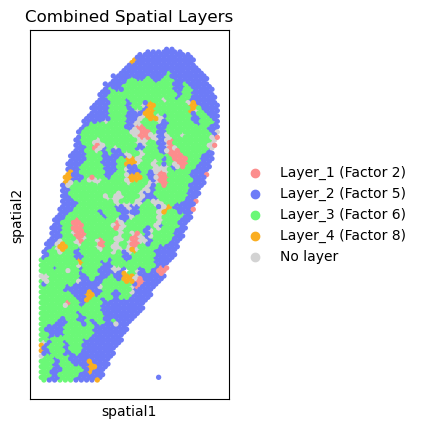


绘制所有图层对比图...


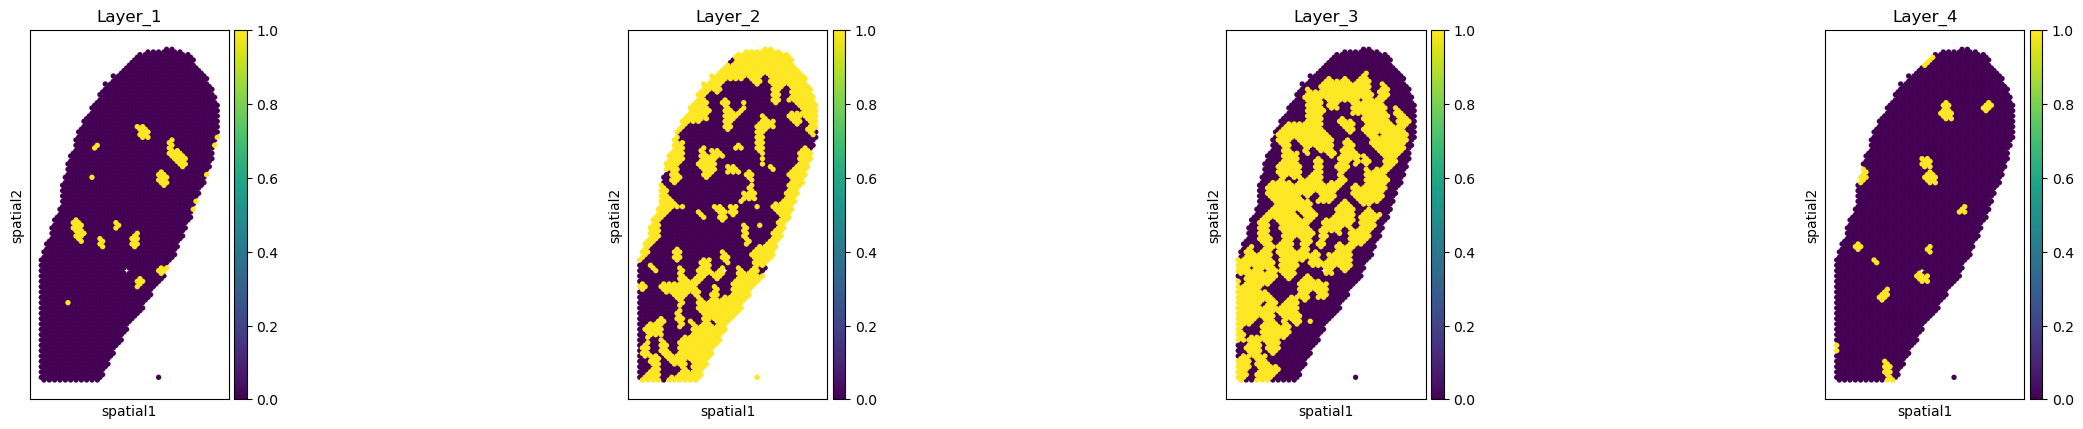

In [20]:
# 1. 首先清除已有的Layer列
layer_cols = [col for col in adata1.obs.columns if col.startswith('Layer_')]
adata1.obs = adata1.obs.drop(columns=layer_cols)
layer_cols = [col for col in adata1.obs.columns if col.startswith('combined_')]
adata1.obs = adata1.obs.drop(columns=layer_cols)
layer_cols = [col for col in adata1.obs.columns if col.startswith('factor_count')]
adata1.obs = adata1.obs.drop(columns=layer_cols)


# 2. 定义要分析的因子
indices = [1, 4, 5, 7]
layer_names = ['Layer_1', 'Layer_2', 'Layer_3', 'Layer_4']
threshold = [0.4, 0.25, 0.6, 0.2]

# 3. 为每个图层创建二进制掩码并保存
layer_data = []
layer_masks = []  # 用于统计

for i, name, thres in zip(indices, layer_names, threshold):
    factor_values = H_exp_np_normalized[:, i]
    binary_mask = np.where(factor_values >= thres, 1, 0)
    layer_data.append(binary_mask)
    layer_masks.append(binary_mask)
    
    # 保存到adata1.obs
    tempp = pd.DataFrame(binary_mask, columns=[name])
    tempp.index = adata1.obs.index
    adata1.obs = adata1.obs.join(tempp)

# 4. 创建合并的图层分类
combined_layer = np.zeros(len(H_exp_np_normalized), dtype=int)
max_values = np.zeros(len(H_exp_np_normalized))

# 用于统计每个点位的因子数量
factor_counts = np.zeros(len(H_exp_np_normalized), dtype=int)

for idx in range(len(H_exp_np_normalized)):
    # 收集超过阈值的因子和它们的值
    over_threshold = []
    factor_count = 0
    
    for layer_idx, values in enumerate(layer_data):
        if values[idx] == 1:
            factor_value = H_exp_np_normalized[idx, indices[layer_idx]]
            over_threshold.append((layer_idx + 1, factor_value))  # +1因为从1开始编号
            factor_count += 1
    
    # 记录这个点位的因子数量
    factor_counts[idx] = factor_count
    
    if over_threshold:
        # 找出最大值对应的因子
        max_layer, max_val = max(over_threshold, key=lambda x: x[1])
        combined_layer[idx] = max_layer
        max_values[idx] = max_val
    else:
        combined_layer[idx] = 0
        max_values[idx] = 0

# 5. 将合并的图层信息保存到adata1.obs
adata1.obs['combined_layer'] = combined_layer
adata1.obs['factor_count'] = factor_counts  # 保存因子数量

# 6. 计算统计信息
total_spots = len(H_exp_np_normalized)

# 计算有2个及以上因子超过阈值的点位数量和比例
spots_with_2_or_more = np.sum(factor_counts >= 2)
spots_with_3_or_more = np.sum(factor_counts >= 3)
spots_with_2_only = np.sum(factor_counts == 2)
spots_with_3 = np.sum(factor_counts == 3)

ratio_2_or_more = spots_with_2_or_more / total_spots * 100
ratio_3 = spots_with_3 / total_spots * 100

print("="*50)
print("阈值分析统计结果")
print("="*50)
print(f"总点位数量: {total_spots}")
print(f"阈值: {threshold}")
print(f"分析的因子: {indices}")
print("-"*50)

# 输出详细统计
print("各点位因子数量分布:")
for count in range(4):  # 0, 1, 2, 3个因子
    num_spots = np.sum(factor_counts == count)
    ratio = num_spots / total_spots * 100
    print(f"  有 {count} 个因子超过阈值: {num_spots} 个点位 ({ratio:.2f}%)")

print("-"*50)
print(f"有 2 个及以上因子超过阈值的点位:")
print(f"  数量: {spots_with_2_or_more} 个")
print(f"  比例: {ratio_2_or_more:.2f}%")

print(f"有 3 个因子超过阈值的点位:")
print(f"  数量: {spots_with_3} 个")
print(f"  比例: {ratio_3:.2f}%")

# 7. 创建分类标签
layer_mapping = {
    0: 'No layer',
    1: 'Layer_1 (Factor 2)',
    2: 'Layer_2 (Factor 5)',
    3: 'Layer_3 (Factor 6)',
    4: 'Layer_4 (Factor 8)'
}
adata1.obs['combined_layer_cat'] = adata1.obs['combined_layer'].map(layer_mapping)

# 创建因子数量分类标签
count_mapping = {
    0: '0 factor',
    1: '1 factor',
    2: '2 factors',
    3: '3 factors'
}
adata1.obs['factor_count_cat'] = adata1.obs['factor_count'].map(count_mapping)

# 8. 使用scanpy绘图
import scanpy as sc

# 8.1 绘制合并图层
sc.pl.spatial(
    adata=adata1,
    color='combined_layer_cat',
    spot_size=2,
    title=f'Combined Spatial Layers',
    palette={
        'No layer': 'lightgray',
        'Layer_1 (Factor 2)': "#FC8D8D",
        'Layer_2 (Factor 5)': "#6D7BF7",  
        'Layer_3 (Factor 6)': "#6BF877",
        'Layer_4 (Factor 8)': "#FAAE21" 
    },
    show=True
)


# 8.3 同时显示所有图
print("\n绘制所有图层对比图...")
sc.pl.spatial(
    adata=adata1,
    color=['Layer_1', 'Layer_2', 'Layer_3', 'Layer_4'],
    spot_size=2,
    show=True
)

In [42]:
adata1.obsm['latent'] = H_exp_np_normalized
sc.pp.neighbors(adata1, use_rep='latent')
sc.tl.leiden(adata1, resolution=0.07, key_added='leiden')

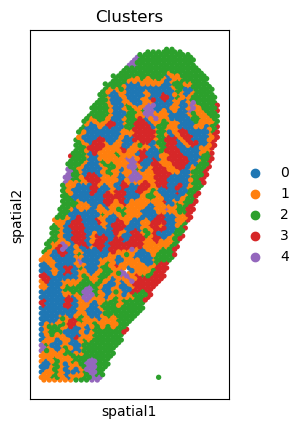

In [43]:
sc.pl.spatial(
    adata1,
    color="leiden",
    spot_size=2,
    title='Clusters'
)

<Axes: title={'center': 'UMAP'}, xlabel='UMAP1', ylabel='UMAP2'>

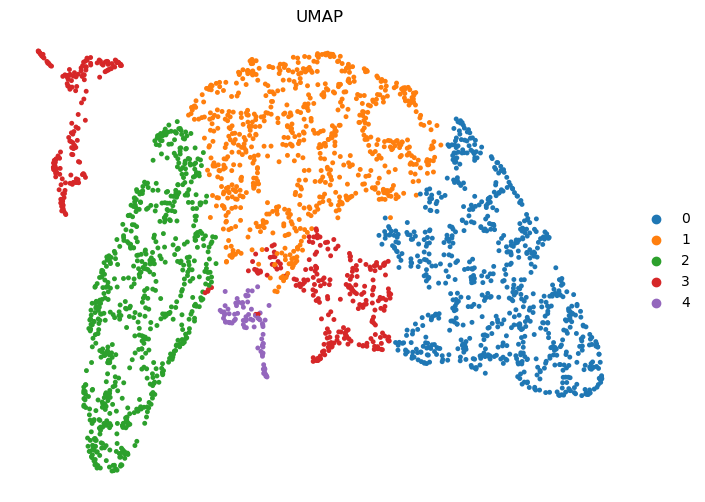

In [44]:
sc.tl.umap(adata1, random_state=42, min_dist=0.3)

# 4. 绘制UMAP图，用聚类结果着色
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sc.pl.umap(
    adata1,
    color='leiden',
    size=50,  # 点的大小
    title='UMAP',
    frameon=False,  # 不显示边框
    ax=ax,
    show=False
)